# Social Media Sanctions and Misinformation Sharing

In [38]:
required_packages = [
    "pandas",
    "numpy",
    "scipy",
    "seaborn",
    "matplotlib",
    "scikit-learn",
    "pingouin",
    "statsmodels",
    "IPython"
]

with open('requirements.txt', 'w') as f:
  for package in required_packages:
      f.write(f"{package}\n")      
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\kdari\anaconda3\lib\site-packages (from -r requirements.txt (line 1)) (2.2.2)



In [39]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.discrete.discrete_model import Probit, Logit
from statsmodels.stats.multitest import multipletests
import pingouin as pg
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

In [40]:
filepath = './mosleh_et_al_data.csv'
df= pd.read_csv(filepath)

## Twitter Suspensions after the 2020 Election

### Crosstab

In [41]:
crosstab = pd.crosstab(df['politics_hashtag'], df['suspended'])
print(crosstab)

suspended            0    1
politics_hashtag           
0                 4295  200
1                 3623  882


The cross tabulation rows show for each politics_hashtag the frequency of a profile using it being suspended. Let's check the odds ratio by dividing the propability of a Trump supporter being suspended to a Biden supporter:

In [42]:
tr_suspended= crosstab[1][1]/(crosstab[1][1]+crosstab[0][1])
bid_suspended= crosstab[1][0]/(crosstab[1][0]+crosstab[0][0])
odds_ratio = tr_suspended / bid_suspended
print(f"It is {odds_ratio:.1f} times more likely for an account using hastag #Trump2020 to be suspended compared to #VoteBidenHarris2020.")

It is 4.4 times more likely for an account using hastag #Trump2020 to be suspended compared to #VoteBidenHarris2020.


### $\chi^2$ test
Our null hypothesis is that there is no relationship between the hashtag a profile uses and them being suspended.
All of the chi-square test assumptions are met, so we proceed:

In [43]:
chi2, pvalue, dof, expected = stats.chi2_contingency(crosstab)
print('Chi squared statistic: ',chi2)
print(f'P-value: ', pvalue)
print('Degrees of freedom: ', dof)

Chi squared statistic:  485.46706126582285
P-value:  1.3808204811294585e-107
Degrees of freedom:  1


- P-value is much smaller than 0.05 so the null hypothesis is rejected. We can conclude that there is a statistically significant association between the hashtag used and the likelihood of account suspension.
- Chi squared statistic is large, showing a big difference between the frequencies of suspension in the crosstab and the expected frequencies of suspension if there was no relationship between the hashtag used and the suspension.

## Distributions of Relative Frequency of Low Quality

### Seaborn Plots

In [44]:
scaler = StandardScaler()
def preprocess_data(df, column, method):
    df_copy = df.copy()
    
    if method == "drop":
        df_copy = df_copy.dropna(subset=[column])
        df_copy[f"{column}_dropped_standardized"] = scaler.fit_transform(df_copy[[column]])
    elif method == "impute_mean":
        df_copy[f"{column}_imputed"] = df_copy[column].fillna(df_copy[column].mean())
        df_copy[f"{column}_imputed_standardized"] = scaler.fit_transform(df_copy[[f"{column}_imputed"]])

    return df_copy

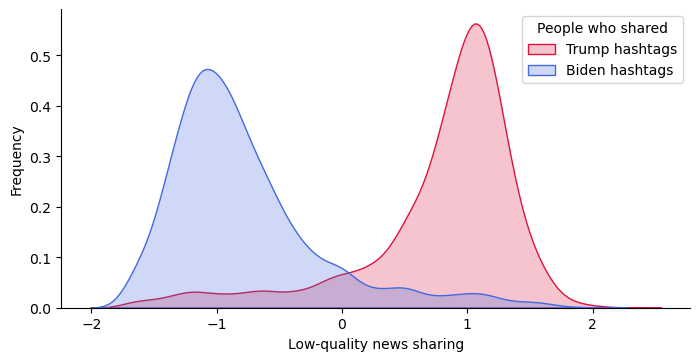

In [45]:
df = preprocess_data(df, 'lowqual_pr2019_fc',method="impute_mean")

g = sns.displot(
    x="lowqual_pr2019_fc_imputed_standardized",
    data=df,
    hue="politics_hashtag",
    kind="kde",
    fill=True,
    aspect=1.6,
    palette={0: "royalblue", 1: "crimson"},
    legend=False,
)
g.figure.set_size_inches(7, 3.5)
plt.legend(title='People who shared', labels=['Trump hashtags', 'Biden hashtags'],  loc='upper right')

plt.xlabel("Low-quality news sharing")
plt.ylabel("Frequency")

plt.show()

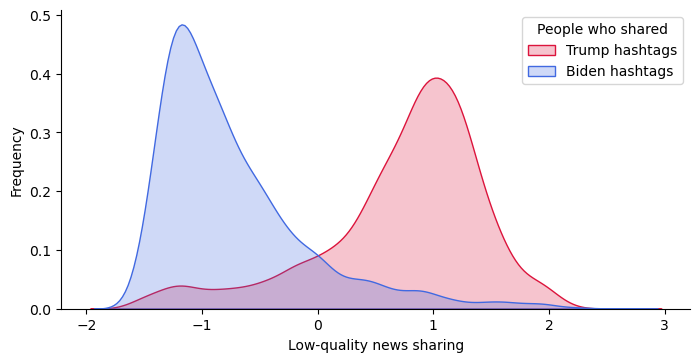

In [46]:
df = preprocess_data(df, 'lowqual_pr2019_crowd',method="impute_mean")

g = sns.displot(
    x="lowqual_pr2019_crowd_imputed_standardized",
    data=df,
    hue="politics_hashtag",
    kind="kde",
    fill=True,
    aspect=1.6,
    palette={0: "royalblue", 1: "crimson"},
    legend=False,
)
g.figure.set_size_inches(7, 3.5)
plt.legend(title='People who shared', labels=['Trump hashtags', 'Biden hashtags'],  loc='upper right')

plt.xlabel("Low-quality news sharing")
plt.ylabel("Frequency")

plt.show()


## Low-quality News Sharing on Twitter

In [47]:
def hedges_g(cohens_d, n1, n2):
    n = n1 + n2
    g = cohens_d * (1 - (3 / (4 * (n1 + n2) - 9)))
    return g

variables = [
    "lowqual_pr2019_fc",
    "lowqual_afm",
    "lowqual_mbfc",
    "lowqual_lasser2019",
    "lowqual_pr2019_crowd",
    "lowqual_pr2019_crowdrep"
]
ttest_results = []
for var in variables:
    df = preprocess_data(df, var,method="impute_mean")

    group0 = df[df["politics_hashtag"] == 0][f"{var}_imputed_standardized"]
    group1 = df[df["politics_hashtag"] == 1][f"{var}_imputed_standardized"]

    t_statistic, p_value = stats.ttest_ind(group0, group1)

    cohens_d = pg.ttest(group0, group1)['cohen-d'].iloc[0]

    hedges_g_value = hedges_g(cohens_d, len(group0), len(group1))

    ttest_results.append({
        "Variable": var,
        "T-statistic": t_statistic,
        "P-value": p_value,
        "Cohen's d": cohens_d,
        "Hedges' g": hedges_g_value
    })

ttests_summary = pd.DataFrame(ttest_results)
display(Markdown(ttests_summary.to_markdown()))

|    | Variable                |   T-statistic |   P-value |   Cohen's d |   Hedges' g |
|---:|:------------------------|--------------:|----------:|------------:|------------:|
|  0 | lowqual_pr2019_fc       |     -118.646  |         0 |     2.50128 |     2.50107 |
|  1 | lowqual_afm             |     -102.664  |         0 |     2.16436 |     2.16418 |
|  2 | lowqual_mbfc            |      -97.5865 |         0 |     2.05731 |     2.05713 |
|  3 | lowqual_lasser2019      |     -102.627  |         0 |     2.16357 |     2.16339 |
|  4 | lowqual_pr2019_crowd    |     -102.097  |         0 |     2.15239 |     2.15221 |
|  5 | lowqual_pr2019_crowdrep |      -60.9931 |         0 |     1.28585 |     1.28574 |

While very small p-value informs us that there is a significant difference between the means of the two groups with different political beliefs, Cohen's d quantifies the effect size for the difference between two group means.

- The negative t-statistics shows that the mean of group0 (hashtag for Biden) is lower than the mean of group 1 (hashtag for Trump). On average, this group of users have recieved lower low quality news sharing ratings than the other.
- Cohen's d suggests that in most cases, the effects magnitude are huge. The only exception is the ratings conducted by the republicans among the 971 participants of the other 4, which is closer to very large (they rated the low qualities between the groups a little more similarly), but still proving the clear difference between the groups of users.
- The sample size is in all cases is bigger than 20. That's why Hedges’ g and Cohen’s d results are roughly equivalent.

### Sharing Lower-quality News Sources and Conservative Ideology

In [48]:
ratings = ['lowqual_pr2019_fc', 'lowqual_lasser2019','lowqual_mbfc','lowqual_afm','lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep']
politics = ['politics_followed','politics_hashtag','politics_sites1','politics_sites2']
for p in politics:
    if (f'{p}_standardized') not in df.columns and p != 'politics_hashtag':
        df[f'{p}_standardized'] = scaler.fit_transform(df[[p]])
for r in ratings:
    if (f'{r}_standardized') not in df.columns:
        df[f'{r}_standardized'] = scaler.fit_transform(df[[r]])
        
ratings = [item + "_standardized" for item in ratings]
politics = [item + "_standardized" if item != 'politics_hashtag' else item for item in politics]

df_subset = df[ratings + politics]
correlation_matrix = df_subset.corr(method='pearson')
correlation_matrix = correlation_matrix.loc[ratings, politics]

rating_politics_correlations = correlation_matrix.copy()
rating_politics_correlations.index.name = 'Low quality news sources'
rating_politics_correlations.columns.name = 'Political ideology'

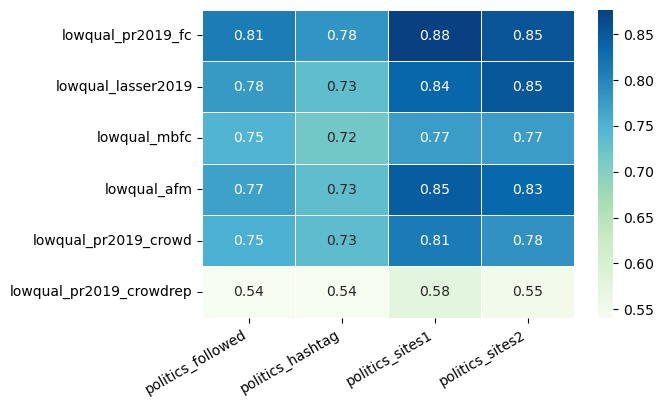

In [49]:
correlation_matrix.columns = correlation_matrix.columns.str.replace('_standardized', '', regex=False)
correlation_matrix.index = correlation_matrix.index.str.replace('_standardized', '', regex=False)

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="GnBu", cbar=True, linewidths=.5)
plt.yticks(rotation=0)
plt.xticks(rotation=30, ha='right')
plt.show()

- Expert sources like fact-checkers and Ad Fontes Media agree in their ratings of low-quality sites (r>0.7).
- Ratings by Republican participants show weaker correlations with other sources as we can see by the lighter color 
(r<0.6), potentially due to ideological differences or biases in their evaluations.
- Also, the crowd seems to mostly agree with the experts in their ratings, so in this case crowdsourcing is a reliable evaluation method.

## News Sharing Can Help Explain Suspension, Using Single Predictors
The probit model predicts the suspension of a user, utilizing two categories of predictors. We evaluate the result using the mean of AUC scores. The confidence interval for the AUC scores are calculated using the percentile method. The CI provides a range within which the true AUC is likely to fall, capturing the uncertainty in our model's performance.

### Data preprocessing

In [50]:
print((df['politics_followed'].isna().sum()/df['politics_followed'].sum())*100)

57.0687845907393


We notice 57% of the politics_followed values are missing. This is a big amount of data, so we need to consider handling them before proceeding with the probit model for this variable. The paper informs us of the existence of bots (accounts with a bot sentinel score >= 50 of 100). 

In [51]:
bot_condition = df['botsentinel_score'] >= 50
bot_count = bot_condition.sum()
print(f"Number of total bots: {bot_count}")

null_politics_followed = df[df['politics_followed'].isnull()]
print(f"Number of NaN in 'politics_followed': {null_politics_followed.shape[0]}")
bots_among_null_followed = null_politics_followed[null_politics_followed['botsentinel_score'] >= 50].shape[0]

print(f"Number of bots among rows with NaN 'politics_followed': {bots_among_null_followed}")

Number of total bots: 2599
Number of NaN in 'politics_followed': 1035
Number of bots among rows with NaN 'politics_followed': 333


<p>Bots are often designed to perform specific tasks, such as posting content, or spreading information while not engaging in typical social media activities, such as following other profiles, or on the opposite they might follow many politics to increace their sense of legitimacy. </p>

<p>Imputation methods, cann't take into consideration this unexpected behavior giving false estimations based on bots' data.

- if we choose to keep the bots, their data might distort the real users' during the imputation.
- if we remove the bots with missing politics_followed (333 out of 1035) we are left with 2266 bots which will heavily influence the imputation.
- removing all 2599 bots, would reduce the dataset's size and diversity, potentially limiting the model's ability to assess the predictive power of the model.
</p>
<p>Based on this, the politics_followed missing values were dropped, as false imputation on this quite big volume of data will distort the results of the probit model. Ideally, we would handle bots seperately, but this is not the goal of the analysis.</p>

### Probit models

In [52]:
np.random.seed(0)
model_stats = []
def probit_model(df, predictor, target, n_bootstraps=100, alpha=0.95):
    X = df[[predictor]]
    y = df[target]
    X = sm.add_constant(X)
    
    boot_auc = []

    for _ in range(n_bootstraps):
        X_boot, y_boot = resample(X, y, replace=True)
        X_boot[predictor] = X_boot[predictor].fillna(X_boot[predictor].mean())

        probit_model = sm.Probit(y_boot, X_boot)
        probit_result = probit_model.fit(disp=0)

        y_pred_prob = probit_result.predict(X_boot)

        auc = roc_auc_score(y_boot, y_pred_prob)
        boot_auc.append(auc)

    lower_bound = np.percentile(boot_auc, 100 * (1 - alpha) / 2)
    upper_bound = np.percentile(boot_auc, 100 * (1 + alpha) / 2)
    mean_auc = np.mean(boot_auc)

    results = pd.DataFrame([{
        "Predictor": predictor,
        "Mean AUC": mean_auc,
        "CI lower bound": lower_bound,
        "CI upper bound": upper_bound
    }])

    return results

predictors = ['politics_hashtag', 'politics_sites1', 'politics_sites2', 
              'lowqual_afm', 'lowqual_mbfc',
              'lowqual_lasser2019', 'lowqual_pr2019_fc', 'lowqual_pr2019_crowd']

for pred in predictors[1:]: #excluding the binary variable from standardizing
    df = preprocess_data(df, pred,method="impute_mean")
predictors[1:] = [item + "_imputed_standardized" for item in predictors[1:]]  

df_copy = preprocess_data(df,'politics_followed',method='drop') #seperate handling for politics followed

for pred in predictors:
    results = probit_model(
        df=df,
        predictor=pred,
        target='suspended',
        n_bootstraps=100,
        alpha=0.95
    )
    model_stats.append(results)
    
results= probit_model(
        df=df_copy,
        predictor='politics_followed_dropped_standardized',
        target='suspended',
        n_bootstraps=100,
        alpha=0.95
    )
model_stats.append(results)

models_eval = pd.concat(model_stats)

row_to_move = models_eval.iloc[-1]
models_eval = models_eval.iloc[:-1]
models_eval = pd.concat(
    [models_eval.iloc[:3], row_to_move.to_frame().T, models_eval.iloc[3:]]
).reset_index(drop=True)

display(Markdown(models_eval.to_markdown()))

|    | Predictor                                 |   Mean AUC |   CI lower bound |   CI upper bound |
|---:|:------------------------------------------|-----------:|-----------------:|-----------------:|
|  0 | politics_hashtag                          |   0.679017 |         0.665047 |         0.689792 |
|  1 | politics_sites1_imputed_standardized      |   0.70126  |         0.68608  |         0.714169 |
|  2 | politics_sites2_imputed_standardized      |   0.704178 |         0.690365 |         0.717286 |
|  3 | politics_followed_dropped_standardized    |   0.714199 |         0.700662 |         0.727102 |
|  4 | lowqual_afm_imputed_standardized          |   0.715404 |         0.704984 |         0.728324 |
|  5 | lowqual_mbfc_imputed_standardized         |   0.706439 |         0.695157 |         0.72066  |
|  6 | lowqual_lasser2019_imputed_standardized   |   0.706082 |         0.692482 |         0.719783 |
|  7 | lowqual_pr2019_fc_imputed_standardized    |   0.700107 |         0.684616 |         0.713226 |
|  8 | lowqual_pr2019_crowd_imputed_standardized |   0.684785 |         0.666633 |         0.698312 |

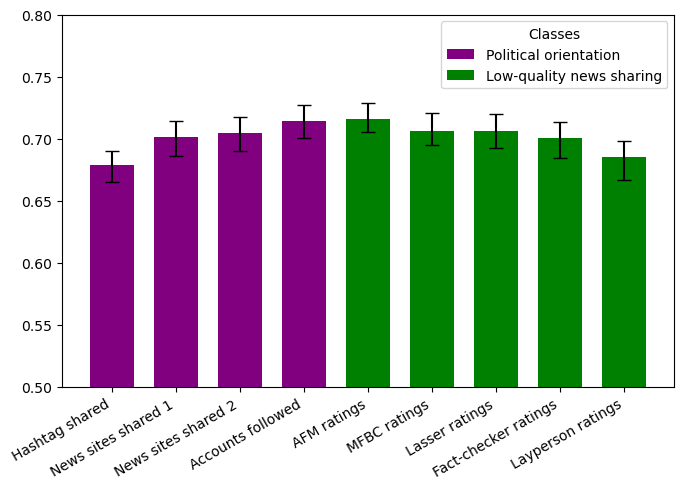

In [53]:
categories = ["Political orientation"] * 4 + ["Low-quality news sharing"] * 5
colors = ["purple" if c == "Political orientation" else "green" for c in categories]

plt.figure(figsize=(7, 5))
x = np.arange(len(models_eval))
bars = plt.bar(
    x, models_eval["Mean AUC"], color=colors, width=0.7,
    yerr=[
        models_eval["Mean AUC"] - models_eval["CI lower bound"], 
        models_eval["CI upper bound"] - models_eval["Mean AUC"]
    ],
    capsize=5
)
predictor_labels= ["Hashtag shared", "News sites shared 1", "News sites shared 2", "Accounts followed",
              "AFM ratings", "MFBC ratings", "Lasser ratings", "Fact-checker ratings", "Layperson ratings"]

plt.xticks(x, predictor_labels, rotation=30, ha="right")
plt.ylim(0.50, 0.80)
plt.legend(
    [bars[0], bars[4]], 
    ["Political orientation", "Low-quality news sharing"], 
    loc="upper right", frameon=True, title="Classes"
)
plt.tight_layout()
plt.show()

- All mean AUC scores have a better ability to predict the suspension of a user than a random guessing model (AUC>0.5). 
- Looking at the mean AUC lowqual_afm seems to be the best performing low quality predictor and the same applies for politics_followed. In general, there are no big differences between the 2 groups of predictors.
- Also, predictors with narrower confidence intervals, showing that AUC has a low variability, result in more stable predictions.

## News Sharing Can Help Explain Suspension, Using Multiple Predictors

### Data preprocessing

In [54]:
def impute_and_transform(df, impute_columns, transform_columns):
    for col in impute_columns + transform_columns:
        df[col] = df[col].fillna(df[col].mean())
        if col in transform_columns:    #transform log(x+1) to avoid infs
            log_col_name = f'log_{col}'
            df[log_col_name] = np.log10(df[col] + 1)
    df[impute_columns] = scaler.fit_transform(df[impute_columns])

    return df

wins_upper_lower = [
    'valence_neg','valence_neu','valence_pos',
    'barbera_std','politics_sites1_std','politics_sites2_ideo_std'
]
wins_upper = [
    'moral_outrage','rewire_abuse','rewire_hate','rewire_profanity','rewire_violent','rewire_sexually_explicit',
    'jigsaw_toxicity','jigsaw_severe_toxicity','jigsaw_idenity_attack','jigsaw_insult','jigsaw_profanity','jigsaw_threat'
]

transform_columns = ['repeated_tweet_count', 'freq_pr_1h', 'num_followers', 'num_friends']
impute_columns = wins_upper_lower + wins_upper 
df = impute_and_transform(df, impute_columns, transform_columns)

df['log_fol'] = np.log10((df['num_friends'] + 1) / (df['num_followers'] + 1))

def winsorize_column(series, lower_limit=0, upper_limit=0):
    winsorized_data = winsorize(series, limits=(lower_limit, upper_limit))
    return pd.Series(winsorized_data, index=series.index)

for col in wins_upper_lower:
    df[col] = winsorize_column(df[col], lower_limit=0.01, upper_limit=0.01)
for col in wins_upper:
    df[col] = winsorize_column(df[col], lower_limit=0, upper_limit=0.01)

### PCA

In [55]:
def perform_pca(columns, n_comp):
    pca = PCA(n_components=n_comp)
    pca.fit(df[columns])
    
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()
    print(f"Variance Ratio: {explained_variance_ratio}")
    print(f"Cumulative Variance: {cumulative_variance}")
    
    x_pca = pca.transform(df[columns])

    pc_df = pd.DataFrame(x_pca, columns=[f'PCA_{i+1}' for i in range(n_comp)])
    print(pc_df)

    loadings = {f'PCA_{i+1}': dict(zip(columns, pca.components_[i])) for i in range(n_comp)}

    print("Predictor Loadings")
    for i in range(n_comp):
        print(f"PCA Component {i+1}:")
        for predictor, coeff in loadings[f'PCA_{i+1}'].items():
            print(f"  {predictor}: {coeff}")

    return pc_df, loadings, explained_variance_ratio, cumulative_variance

In [56]:
low_qual_columns = ['lowqual_afm_imputed_standardized', 'lowqual_mbfc_imputed_standardized', 'lowqual_lasser2019_imputed_standardized', 'lowqual_pr2019_fc_imputed_standardized']
pc1_misinfo, loadings_misinfo, var_ratio, cu_var = perform_pca(low_qual_columns,1)

Variance Ratio: [0.87255953]
Cumulative Variance: [0.87255953]
         PCA_1
0    -1.643266
1     3.919070
2    -2.290660
3    -1.643703
4     2.426475
...        ...
8995 -1.071716
8996  2.415044
8997 -1.187753
8998  2.355411
8999 -1.812329

[9000 rows x 1 columns]
Predictor Loadings
PCA Component 1:
  lowqual_afm_imputed_standardized: 0.5112952833340252
  lowqual_mbfc_imputed_standardized: 0.47689301244064375
  lowqual_lasser2019_imputed_standardized: 0.5108405266636451
  lowqual_pr2019_fc_imputed_standardized: 0.5001921073384478


After fitting PCA on our standardized data, we check the variance ratio. The component explains 87% of the variance of our data. We proceed to projecting the political orientation dimensions to the new dimension.<br>
Looking at the coefficients, we notice that the standardized lowqual_afm has the strongest influence on the principal component.

In [57]:
df = preprocess_data(df,'politics_followed',method='impute_mean') #imputing with the column mean, as stated in the study
politics_columns = ['politics_hashtag', 'politics_sites1_imputed_standardized', 'politics_sites2_imputed_standardized', 'politics_followed_imputed_standardized']
pc1_politics, loadings_politics, var_ratio_politics, cu_var_politics = perform_pca(politics_columns,1)
df['extremity'] = np.abs(pc1_politics)

Variance Ratio: [0.89572961]
Cumulative Variance: [0.89572961]
         PCA_1
0    -1.627939
1     2.095475
2    -1.917552
3    -1.619439
4     2.522418
...        ...
8995 -0.941135
8996  2.019410
8997 -1.328168
8998  1.760832
8999 -1.753236

[9000 rows x 1 columns]
Predictor Loadings
PCA Component 1:
  politics_hashtag: 0.25692941302001726
  politics_sites1_imputed_standardized: 0.5673069160520016
  politics_sites2_imputed_standardized: 0.5638746477428245
  politics_followed_imputed_standardized: 0.5423979363508519


In [58]:
fol_columns = ['log_num_followers','log_num_friends','log_fol']
df[fol_columns] = scaler.fit_transform(df[fol_columns])
pc1_fol, loadings_fol, var_ratio_fol, cu_var_fol = perform_pca(fol_columns,1)

Variance Ratio: [0.70462969]
Cumulative Variance: [0.70462969]
         PCA_1
0    -1.367920
1    -0.691199
2    -1.643654
3     3.280269
4    -0.580975
...        ...
8995  0.793181
8996 -1.933270
8997  0.178827
8998 -1.107122
8999  0.164176

[9000 rows x 1 columns]
Predictor Loadings
PCA Component 1:
  log_num_followers: -0.6874423377499677
  log_num_friends: -0.5715778620730412
  log_fol: 0.4480198431508042


In [59]:
harm_columns = wins_upper[1:]
pc_harm, loadings_harm, var_ratio_harm, cu_var_harm = perform_pca(harm_columns,3)
pc1_harmful_language = pd.DataFrame(pc_harm['PCA_1'])
pc2_harmful_language = pd.DataFrame(pc_harm['PCA_2'])
pc3_harmful_language = pd.DataFrame(pc_harm['PCA_3'])

Variance Ratio: [0.59475122 0.13179091 0.07837182]
Cumulative Variance: [0.59475122 0.72654213 0.80491395]
         PCA_1     PCA_2     PCA_3
0     2.320698 -0.614727  0.345081
1     0.729504 -1.812451 -0.089623
2     1.701250 -0.355623  0.217948
3     2.236155  0.317945 -0.229991
4    -1.797753 -0.668539  0.007172
...        ...       ...       ...
8995  4.342555  1.505818  0.681973
8996 -1.194124 -0.227314 -0.356109
8997  3.207604  1.570970 -1.573787
8998  4.565557  2.440672 -1.932665
8999 -0.766608 -0.634252  0.114949

[9000 rows x 3 columns]
Predictor Loadings
PCA Component 1:
  rewire_abuse: 0.3926462848409443
  rewire_hate: 0.2737991643405051
  rewire_profanity: 0.25560504164930786
  rewire_violent: 0.19179212540978166
  rewire_sexually_explicit: 0.12172506220410265
  jigsaw_toxicity: 0.4406459973162034
  jigsaw_severe_toxicity: 0.24233942210062026
  jigsaw_idenity_attack: 0.21833875456131602
  jigsaw_insult: 0.4263697305887265
  jigsaw_profanity: 0.3872410268547787
  jigsaw_thre

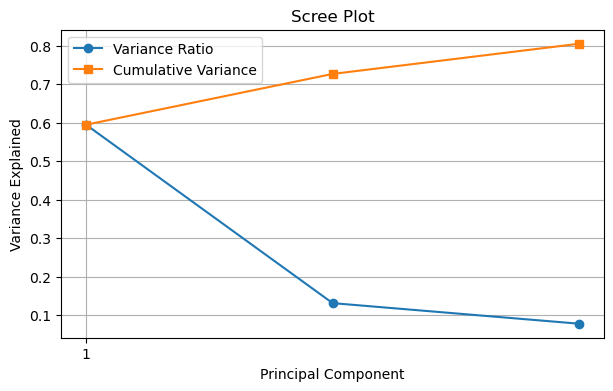

In [60]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(var_ratio_harm) + 1), var_ratio_harm, marker='o', label='Variance Ratio')
plt.plot(range(1, len(cu_var_harm) + 1), cu_var_harm, marker='s', label='Cumulative Variance')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(var_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

In the previous cases, using one pca component was explaining most of the variance of our data (Variance ratios 0.9 and 0.89). Here, the first component captures only a little over half of the total variance, leaving a good percentage of unexplored variance.
<p> 3 components are needed because they collectively explain 90% of the variance as by the cumulative variance of the 3 components combined. The scree plot shows a steep drop in variance explained after PC1, followed by smaller contributions from PC2 and PC3. Including more components would add little value, as the additional variance explained by components beyond PC3 is minimal.</p>
<p>Each PCA seems to also explain the interaction between different features:</p>
<p>

- pc1_harmful_language: jigsaw_toxicity, jigsaw_insult and jigsaw_profanity have the biggest coefficients. They seem to be variables that provide a general measure of the presence of harming language.
- pc2_harmful_language: rewire_abuse and rewire_hate have big negative loading, while rewire_sexually_explicit has clearly the biggest positive one. This component may differenciate hateful/abusive from sexually explicit language.
- pc3_harmful_language: jigsaw_threat and jigsaw_identity_attack have the biggest loadings with some other variables having moderate negative ones. Similar to the previous one it possibly distinguishes identity attacks and threats from other forms of abusive language.

</p>

In [61]:
val_columns = ['valence_neg','valence_neu','valence_pos']
pc1_valence, loadings_val, var_ratio_val, cu_var_val = perform_pca(val_columns,1)

Variance Ratio: [0.71038802]
Cumulative Variance: [0.71038802]
         PCA_1
0    -0.993828
1    -1.765461
2    -0.765704
3    -2.232411
4     0.965901
...        ...
8995  1.003932
8996  0.283907
8997  0.492452
8998 -1.177928
8999  0.238550

[9000 rows x 1 columns]
Predictor Loadings
PCA Component 1:
  valence_neg: -0.46144737081911846
  valence_neu: 0.6900308113725411
  valence_pos: -0.5576054190201838


In [62]:
pca_data = [pc1_politics, pc1_misinfo, pc1_fol, pc1_harmful_language,
            pc2_harmful_language, pc3_harmful_language, pc1_valence]
pca_columns = ['pc1_politics', 'pc1_misinfo', 'pc1_fol', 'pc1_harmful_language',
               'pc2_harmful_language', 'pc3_harmful_language', 'pc1_valence']

for column_name, data in zip(pca_columns, pca_data):
    df[column_name] = scaler.fit_transform(data).flatten() 

columns_to_normalize = [
    "tweets_in_2wk", "botsentinel_score", "extremity", "moral_outrage",
    "liwc_political", "log_freq_pr_1h", "log_repeated_tweet_count",
    "barbera_std", "politics_sites1_std", "politics_sites2_ideo_std"
]

X = pca_columns + columns_to_normalize
df = impute_and_transform(df, X, [])

In [63]:
def evaluate_model(df, X_columns, y_column, model_type="probit"):
    X = df[X_columns]
    y = df[y_column]

    X = sm.add_constant(X)

    if model_type == "probit":
        model = Probit(y, X)
    elif model_type == "logit":
        model = Logit(y, X)

    result = model.fit(disp=False)
    p_values = result.pvalues

    bonf_reject, bonf_p_values, _, _ = multipletests(p_values, method='bonferroni')

    holm_reject, holm_p_values, _, _ = multipletests(p_values, method='holm')

    results_df = pd.DataFrame({
        'Predictor': p_values.index,
        'P-value': [f"{val:.10f}" for val in p_values.values],
        'Bonferroni Corrected P-value': [f"{val:.10f}" for val in bonf_p_values],
        'Bonferroni Reject H0': bonf_reject,
        'Holm Corrected P-value': [f"{val:.10f}" for val in holm_p_values],
        'Holm Reject H0': holm_reject
    })
    results_df = results_df.iloc[1:]
    return results_df

probit_results = evaluate_model(df, X, 'suspended', model_type="probit")
print("Probit Model Results:")
print(probit_results)

logit_results = evaluate_model(df, X, 'suspended', model_type="logit")
print("\nLogit Model Results:")
print(logit_results)

Probit Model Results:
                   Predictor       P-value Bonferroni Corrected P-value  \
1               pc1_politics  0.0534333173                 0.9617997119   
2                pc1_misinfo  0.0000000059                 0.0000001057   
3                    pc1_fol  0.9304066424                 1.0000000000   
4       pc1_harmful_language  0.0000000004                 0.0000000069   
5       pc2_harmful_language  0.0000140457                 0.0002528220   
6       pc3_harmful_language  0.2168979907                 1.0000000000   
7                pc1_valence  0.0594293340                 1.0000000000   
8              tweets_in_2wk  0.0000000000                 0.0000000000   
9          botsentinel_score  0.0000005231                 0.0000094161   
10                 extremity  0.0000000004                 0.0000000067   
11             moral_outrage  0.6789467874                 1.0000000000   
12            liwc_political  0.5675933721                 1.0000000000   
13 

H₀: Political orientation has no effect on suspension.
- Political orientation is respresented in the model by the pc1_politics. The p-value before the correction is a little over 0.05 meaning there is no statistically significant evidence that political orientation influences suspension. However, 0.053 is close to the threshold of 0.05 suggesting that political orientation might have a small or borderline effect on suspension.
- After the conservative Bonferroni correction of p-value, we notice it is far above the significance threshold. There is no evidence that political orientation influences suspension.
- Using the less conservative Holm correction, the null hypothesis that political orientation has no effect on suspension cannot be rejected.
<p>Conclusion: There is no statistically significant evidence to suggest that political orientation influences suspension. Other predictors, such as misinformation and harmful language are much stronger determinants of suspension. </p>